# 教程 6：银河双星和 RJMCMC

在第六个教程中，我们将研究银河双星波形。然后在定维 MCMC 和 RJMCMC 中使用它们。我们将使用 RJMCMC ，并根据数据中的源数量进行模型选择。

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from lisatools.utils.constants import *
from copy import deepcopy  # can be useful
from lisatools.utils.constants import *
from lisatools.sensitivity import get_sensitivity

## 任务 1：使用 GBGPU 构建并绘制银河二进制波形

首先使用 GBGPU 生成银河二进制波形。选择合理的参数，建立波形并将其与 LISA A 频道 TDI 灵敏度曲线（A1TDISens）绘制在特征应变表示中。波形生成后，可以访问并更新作为类属性的信息。

In [2]:
# imports
from gbgpu.gbgpu import GBGPU

In [3]:
gb = GBGPU()

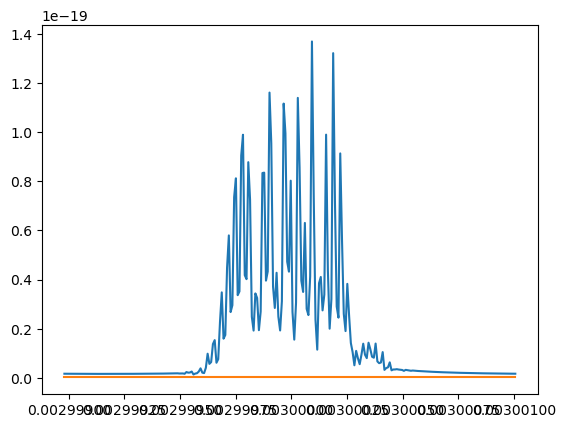

In [4]:
amp = 2e-23  # amplitude
f0 = 3e-3  # f0
fdot = 7.538331e-18  # fdot
fddot = 0.0 # fddot
phi0 = 0.1  # initial phase
inc = 0.2  # inclination
psi = 0.3  # polarization angle
lam = 0.4  # ecliptic longitude
beta = 0.5  # ecliptic latitude

Tobs = 4 * YRSID_SI
    
gb.run_wave(amp, f0, fdot, fddot, phi0, inc, psi, lam, beta, N=256)  # T=Tobs, oversample=4)
plt.plot(gb.freqs[0], gb.freqs[0] * np.abs(gb.A[0]))
plt.plot(gb.freqs[0], get_sensitivity(gb.freqs[0], sens_fn="A1TDISens", return_type="char_strain"))

## 任务 2：在单个 GB 源上运行 MCMC

使用选定的 GB 源运行固定维度 MCMC。暂时固定天空位置，以简化问题的计算（这对下一节使用 GB 的 RJ 尤为重要）。因此，将对 8 个参数中的 6 个进行采样。讨论或思考这些参数的合理先验值，以及如何确定这些先验值。为了简单起见，我们建议在这个示例设置中使用紧密（但不是太紧密）约束的均匀分布。

在 GBGPU 类中有一个更快的 get_ll 方法。不过，使用完整的 AnalysisContainer 设置可能更简单。这将使 RJ 部分更直接，但实际上对于 GB 上的固定维度 MCMC 并不理想。

运行完成后，用 chainconsumer 或 corner 绘制后验分布图。

In [5]:
from eryn.prior import uniform_dist, ProbDistContainer

In [6]:
priors = {"gb": ProbDistContainer({
    0: uniform_dist(1e-23, 1e-21),
    1: uniform_dist(0.00299995, 0.00300005),
    2: uniform_dist(1e-18, 1e-17),
    3: uniform_dist(0.0, 2 * np.pi),
    4: uniform_dist(0.0, np.pi),  # should be over cosine of inclination, but this is simpler for examples
    5: uniform_dist(0.0, np.pi)
})}
lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])

In [7]:
from lisatools.analysiscontainer import AnalysisContainer
from lisatools.datacontainer import DataResidualArray
from lisatools.sensitivity import AE1SensitivityMatrix
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [8]:
N_wave = 256
def like_wrap(x, analysis1, data, fd, Tobs, dt, default_values):
    input_parameters = np.zeros(9)
    input_parameters[np.array([0, 1, 2, 4, 5, 6])] = x
    input_parameters[np.array([7, 8])] = default_values
    # print(input_parameters)
    gb.run_wave(*input_parameters, T=Tobs, dt=dt, N=N_wave)  # T=Tobs, oversample=4)
    
    A = gb.A[0]
    E = gb.E[0]
    # print(A[::100], check[0][::100])
    # print(gb.freqs[0][::100], check_freqs[::100])

    start_ind = int(gb.freqs[0][0] / df)
    template = DataResidualArray(np.array([A, E]), f_arr=gb.freqs[0])
    data_tmp = DataResidualArray(data[:, start_ind:start_ind + N_wave], f_arr=fd[start_ind:start_ind + N_wave])
    sens_mat = AE1SensitivityMatrix(data_tmp.f_arr)
    analysis = AnalysisContainer(data_tmp, sens_mat)
    # fig, ax = data_tmp.loglog()
    # print(data_tmp.shape)
    # plt.show()
    # template.loglog()
    # plt.show()
    ll = analysis.template_likelihood(template)
    return ll

In [9]:
injection_params = np.array([
    amp, 
    f0,
    fdot,
    0.0,
    phi0,
    inc,
    psi,
    lam,
    beta
])
print(injection_params)

Tobs = YRSID_SI
dt = 5.0
N = int(Tobs / dt)
Tobs = N * dt
df = 1 / Tobs
# TODO: fix DataREsidualArray frequency check error here with df=
f_arr = np.arange(0.0, 1/(2 * dt) + df, df)
data_orig = np.asarray(gb.inject_signal(*injection_params, T=Tobs, dt=dt, N=N_wave))
data = DataResidualArray(data_orig.copy(), f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data, sens_mat)

[ 2.000000e-23  3.000000e-03  7.538331e-18  0.000000e+00  1.000000e-01
  2.000000e-01  3.000000e-01  4.130000e+00 -1.500000e-01]


/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [10]:
sampling_injection_params = np.array([
    amp,
    f0,
    fdot,
    phi0,
    inc,
    psi
])
print(f0)
like_wrap(sampling_injection_params, analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values)

0.003


-0.0

In [11]:
from eryn.ensemble import EnsembleSampler
from eryn.state import State

In [12]:
ndims = {"gb": 6}
nwalkers = 24
ntemps = 10
sampler = EnsembleSampler(
    nwalkers,
    ndims, 
    like_wrap,
    priors,
    branch_names=["gb"],
    args=(analysis, data_orig, analysis.data_res_arr.f_arr, Tobs, dt, default_values),
    tempering_kwargs=dict(ntemps=10),
    nleaves_max={"gb": 1},
)

In [13]:
start_state = State({"gb": priors["gb"].rvs(size=(ntemps, nwalkers, 1))})

In [14]:
nsteps = 2000
sampler.run_mcmc(start_state, nsteps, burn=1000, progress=True)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2000/2000 [08:43<00:00,  3.82it/s]


In [15]:
from chainconsumer import Chain, ChainConsumer
import pandas as pd

Parameter fdot in chain 1 is not constrained
Parameter inc in chain 1 is not constrained
Parameter psi in chain 1 is not constrained


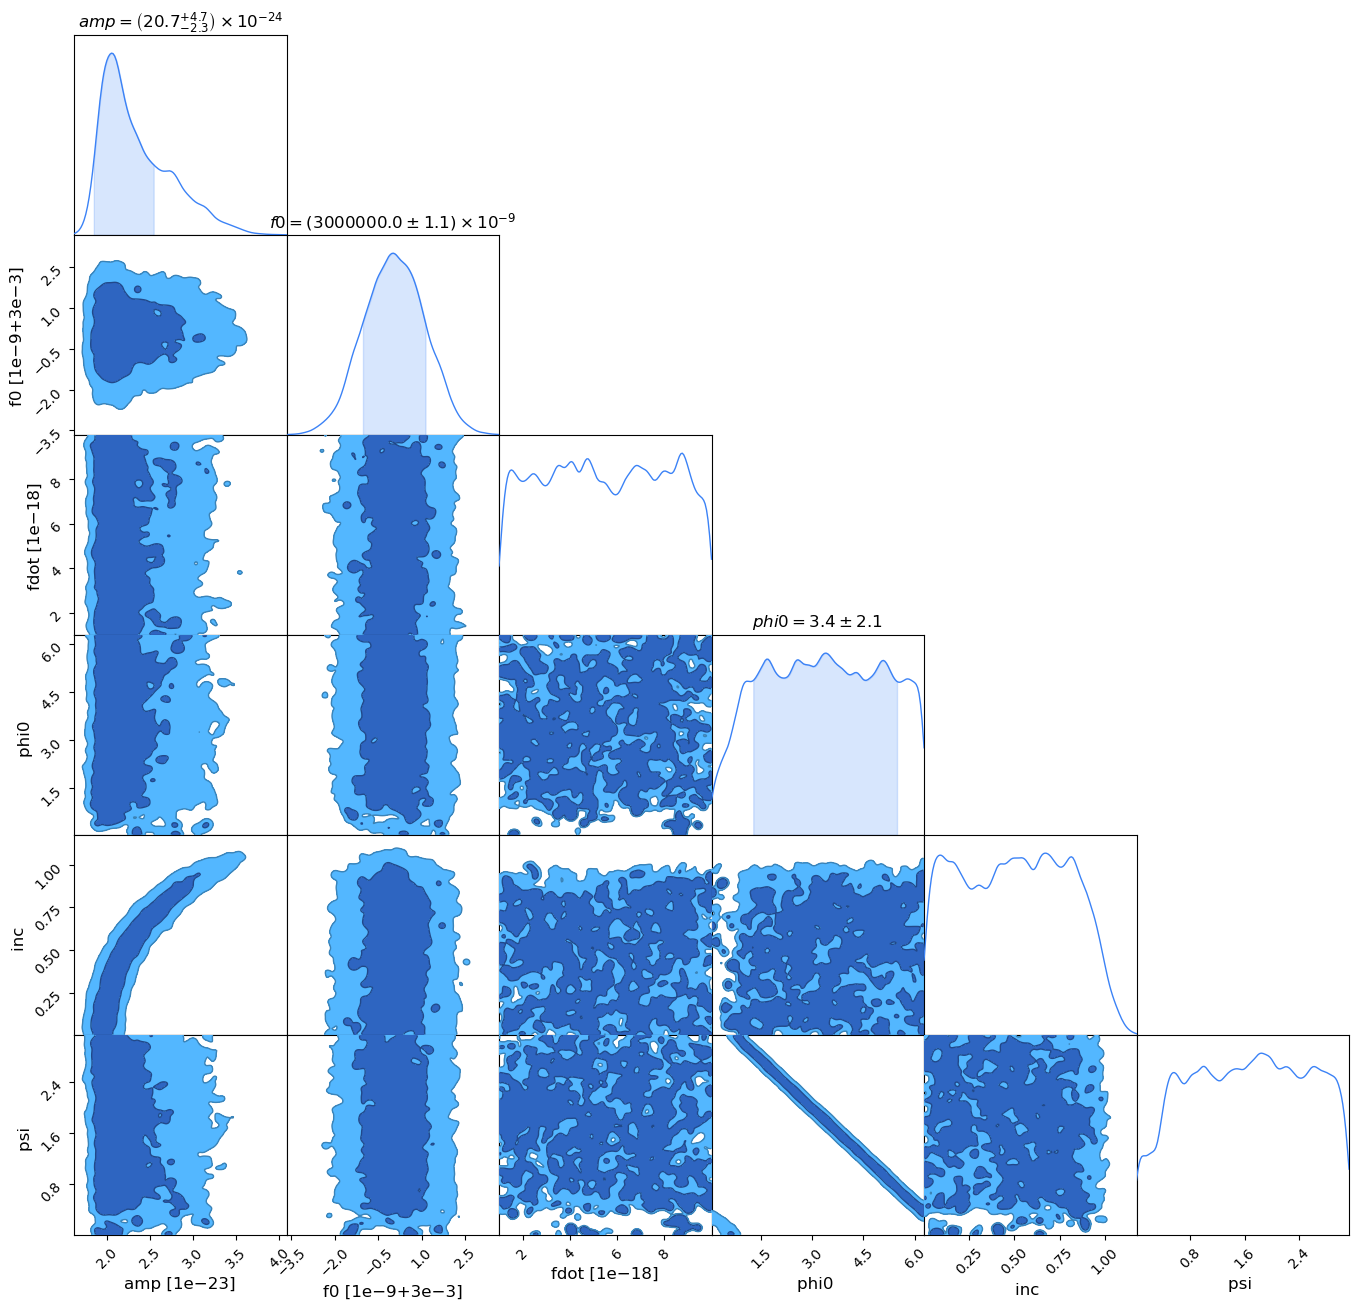

In [16]:
cold_chain = sampler.get_chain()["gb"][:, 0, :, 0].reshape(-1, 6)
c = ChainConsumer()

df1 = pd.DataFrame({name: val for name, val in zip(["amp", "f0", "fdot", "phi0", "inc", "psi"], cold_chain.T)}) 
c.add_chain(Chain(samples=df1, name=str(1)))
fig = c.plotter.plot()

## 任务 3：RJ 与 GBs

最后一项任务是在一些近距离银河双星上运行 RJMCMC。这里的关键部分是 "全局 "似然函数。我们将努力建立一个函数，从 Eryn 获取长度可调的模板数组，并在进行似然计算之前将其汇总为一个全局模板。这有点繁琐，但对理解这一过程非常重要。

这个问题还有一个细微差别。在只有一个二进制的固定维度情况下，默认的拉伸建议实际上对每个维度的比例都是不变的，因为在提出建议时不会混合维度信息$\vec{Y} = \vec{X}_j + z\left(\vec{X}_i - \vec{X}_j\right)$。教程 5 中使用的默认高斯运动（GaussianMove）需要对协方差矩阵进行反演。如果我们对上面使用的参数进行采样($A$, $f_0$, $\dot{f}$, etc.)，参数之间的比例差异将导致矩阵反演和乘法的数值问题。

解决这个问题的方法有很多种。以下是两种可能性：

1) 可以对数缩放并缩小每个参数，使它们的阶数都为 1。这需要改变先验值，并确保在似然函数中包含这种转换。比如使用 eryn.utils.TransformContainer 进行转换。
2) 可以创建自己的方案，假设协方差为对角线，然后自己生成信息。答案中采用了这种方法。提示：Eryn 教程中有这样一个例子。

如果真的想使用特别的方法：
在描述的设置中，当前 inds=True 的每个源都会一起移动。也就是说，如果某个行走器有 5 个源代码，那么所有 5 个源代码的参数都会同时改变。这会影响这些移动的接受率。在现实中，你可能希望使用吉布斯采样一次对一个或几个源进行采样。您可以使用 eryn.moves.Move 的 gibbs_sampling_setup kwarg 来做到这一点。
如果可以运行采样器并确认 Likelihoods 正常工作，那么就可以认为本教程已经完成。本教程所分配的时间以及运行 RJ 设置所需的整体设置都需要更多的运行时间才能获得合理的结果。因此，可以绘制出结果，但随着运行采样器的时间延长，结果会越来越准确。

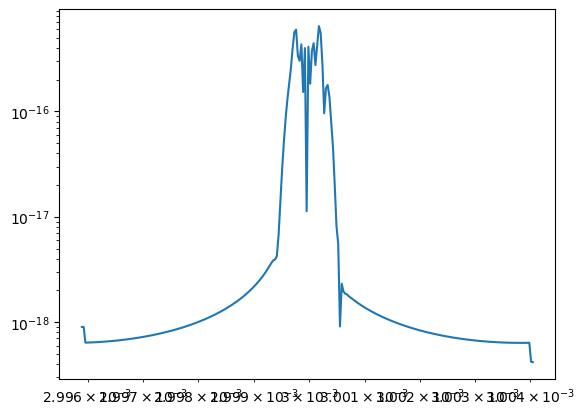

In [17]:
# imports
from eryn.moves import MHMove
def fill_template(template, A, E, freqs, Tobs, dt):
    for i in range(A.shape[0]):
        start_ind = gb.start_inds[i]
        end_ind = start_ind + N_wave
        
        assert end_ind - start_ind == gb.freqs.shape[1]
        template[0, start_ind:end_ind] += A[i]
        template[1, start_ind:end_ind] += E[i]

def generate_global_template(template, params_all, Tobs, dt):
    gb.run_wave(*params_all.T, T=Tobs, dt=dt, N=N_wave)  # Te=Tobs, oversample=4)
    fill_template(template, gb.A, gb.E, gb.freqs, Tobs, dt)
    
def global_log_likelihood(params_all, analysis, Tobs, dt, default_values):
    input_parameters = np.zeros((params_all.shape[0], 9))
    input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = params_all
    input_parameters[:, np.array([7, 8])] = default_values
    # print(input_parameters)
    
    template = np.zeros_like(analysis.data_res_arr[:])

    generate_global_template(template, input_parameters, Tobs, dt)
    template_in = DataResidualArray(template, f_arr=f_arr)
    ll = analysis.template_likelihood(template_in)
    return ll
injection_params_all = priors["gb"].rvs(size=5)
input_parameters = np.zeros((injection_params_all.shape[0], 9))
input_parameters[:, np.array([0, 1, 2, 4, 5, 6])] = injection_params_all
input_parameters[:, np.array([7, 8])] = default_values
data = np.zeros((2, len(f_arr)), dtype=complex)

generate_global_template(data, input_parameters, Tobs, dt)
inds = np.where(data[0])
plt.loglog(f_arr[inds], np.abs(data[0][inds]))

In [18]:
data_arr = DataResidualArray(data, f_arr=f_arr)
sens_mat = AE1SensitivityMatrix(f_arr)
analysis = AnalysisContainer(data_arr, sens_mat)

/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:83: RuntimeWarning: divide by zero encountered in divide
  Sa_a = Sa_a_in * (1.0 + (0.4e-3 / frq) ** 2) * (1.0 + (frq / 8e-3) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:85: RuntimeWarning: divide by zero encountered in power
  Sa_d = Sa_a * (2.0 * np.pi * frq) ** (-4.0)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:87: RuntimeWarning: invalid value encountered in multiply
  Sa_nu = Sa_d * (2.0 * np.pi * frq / C_SI) ** 2
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:92: RuntimeWarning: divide by zero encountered in divide
  Soms_d = Soms_d_in * (1.0 + (2.0e-3 / f) ** 4)
/home/txr/anaconda3/envs/lisa_env/lib/python3.12/site-packages/lisatools/sensitivity.py:94: RuntimeWarning: invalid value encountered in multiply
  Soms_nu = Soms_d * (2.0 * np.pi * frq / C_SI) ** 2


In [ ]:
class NonScaledDiagonalGaussianMove(MHMove):
    def __init__(self, cov_all, *args, **kwargs):

        for branch_name, cov in cov_all.items():
            assert isinstance(cov, np.ndarray) and cov.ndim == 1

        self.cov = cov_all
        super(NonScaledDiagonalGaussianMove, self).__init__(*args, **kwargs)
        
    def get_proposal(self, branches_coords, random, branches_inds=None, **kwargs):

        assert branches_inds is not None
        new_points = {}
        for name, cov in self.cov.items():
            assert name in branches_coords
            coords = branches_coords[name]
            inds = branches_inds[name]
            
            ntemps, nwalkers, nleaves_max, ndim = coords.shape

            # generate sigma from normal distribution
            sigma = random.randn(ntemps, nwalkers)

            tmp = np.zeros_like(coords)

            tmp = coords + sigma[:, :, None, None] * cov[None, None, None, :]
            # symmetric
            new_points[name] = np.zeros_like(coords)

            # this is not necessary as the inds will remove there changes in the parent class
            # but I put it here to indicate to think about it
            new_points[name][inds] = tmp[inds]

        # symmetric
        factors = np.zeros((ntemps, nwalkers))
            
        return new_points, factors
nleaves_max = {"gb": 10}
nleaves_min = {"gb": 0}
ndims = {"gb": 6}

nwalkers = 14
ntemps = 12

lam = 4.13
beta = -0.15

# [lam, beta] of galactic center
default_values = np.array([lam, beta])

cov    = {"gb": np.array([1e-24, 1e-10, 1e-19, 0.01, 0.01, 0.01])}
moves = NonScaledDiagonalGaussianMove(cov)

sampler_rj = EnsembleSampler(
    nwalkers,
    ndims,
    global_log_likelihood,
    priors,
    branch_names=["gb"],
    nleaves_max=nleaves_max,
    nleaves_min=nleaves_min,
    args=(analysis, Tobs, dt, default_values),
    rj_moves=True,
    moves=moves,
    tempering_kwargs=dict(ntemps=ntemps)
)
start_points = {"gb": priors["gb"].rvs(size=(ntemps, nwalkers, nleaves_max["gb"]))}
inds_tmp = np.zeros((ntemps, nwalkers, nleaves_max["gb"]), dtype=bool)
inds_tmp[:, :, 1] = True

start_state = State(start_points, inds={"gb": inds_tmp})

# lp = sampler_rj.compute_log_prior(start_state.branches_coords, inds=start_state.branches_inds)
# ll = sampler_rj.compute_log_like(start_state.branches_coords, inds=start_state.branches_inds, logp=lp)
# start_state.log_prior = lp
# start_state.log_like = ll

nsteps = 10
end_state = sampler_rj.run_mcmc(start_state, nsteps, progress=True)

### 学习总结
这是最后一个任务，运用MCMC和RJMCMC去分析实例银河双星波形，因为工作量较大，时间较短，我使用了教程库中的代码，并尝试分析它的编写过程和得到的结论。
首先，通过数据去构建波形，这里使用的是GBGPIU这个模板，然后设置各种初始参数（与之前的操作一样）最后生成波，用plot画图。我们看到生成的波形是一个中间突起的有很多峰值的图像。
接下来，选择GB源运行MCMC，寻找峰值，因为波形的峰较多，实际上固定维度的MCMC效果并不好，因此后面使用了RJ方法。这里需要一些特定的假设和操作，才能正确地使用方法。首先我们需要一个全局似然函数，这个函数的建立方法是从Eryn中得到一些模板数组并将其汇总；接下来，我们还要对矩阵进行处理，以便矩阵运算中不会出现数值错误，或者假设协方差在对角线再生成一些信息。
运行后我们发现生成的结果具有了一定的细节，且大致分布情况与真实分布相似，虽然遗漏了真实的分布中央的一些小细节，但可以反映一定的波形信息，如果要得到更准确的结论，可能要更长的运算时间和更好的性能。